<a href="https://colab.research.google.com/github/kamalsinha7305/Pneumonia-Detection-in-Chest-X-Ray-Images-Using-CNN-and-Explainable-AI/blob/main/pnemonia_detection_in_check_xray_final_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Part 1: Imports and Setup
# Standard imports from your original notebook
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras import layers, models

# New import for Transfer Learning
import tensorflow_hub as hub

# Scikit-learn for evaluation
from sklearn.metrics import classification_report, confusion_matrix

# OpenCV for Grad-CAM visualization
import cv2

print("TensorFlow Version:", tf.__version__)
print("TensorFlow Hub Version:", hub.__version__)

TensorFlow Version: 2.19.0
TensorFlow Hub Version: 0.16.1


In [2]:
# Part 1: Imports and Data Download (Corrected)

import kagglehub
# This command downloads the dataset and returns the path where it's stored.
# This MUST be the first step to ensure the files exist.
print("Downloading dataset from Kaggle Hub...")
dataset_path_str = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

# Now, create the Path object from the returned string
BASE = Path(dataset_path_str)

print(f"Dataset downloaded to: {BASE}")
print(f"Directory exists: {BASE.exists()}")
print(f"Contents of BASE: {os.listdir(BASE)}")


# Part 2: Dataset Loading and Preparation (This should now work)
IMG_SIZE = (224, 224)
BATCH = 32

# The actual data is in a subfolder named 'chest_xray'
DATA_DIR = BASE / 'chest_xray'

# Part 2: Dataset Loading and Preparation (with Augmentation in the Pipeline)

# Define the data augmentation as a sequential model
# This keeps it separate from the main model architecture
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
], name="data_augmentation")


def make_ds(folder, shuffle=True, augment=False):
    """
    Loads a dataset, normalizes it, and optionally applies data augmentation.
    """
    ds = tf.keras.utils.image_dataset_from_directory(
        folder,
        image_size=IMG_SIZE,
        batch_size=BATCH,
        label_mode="binary",
        shuffle=shuffle
    )
    class_names = ds.class_names

    # Normalize the images to [0, 1]
    ds = ds.map(lambda x, y: (x / 255.0, y), num_parallel_calls=tf.data.AUTOTUNE)

    # Apply augmentation ONLY to the training dataset
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)

    # Prefetch for performance
    return ds.prefetch(tf.data.AUTOTUNE), class_names

# Load the datasets using the new function
train_ds, class_names = make_ds(DATA_DIR / "train", shuffle=True, augment=True)
val_ds, _ = make_ds(DATA_DIR / "val", shuffle=False, augment=False)
test_ds, _ = make_ds(DATA_DIR / "test", shuffle=False, augment=False)

print("\nSuccessfully loaded datasets with augmentation in the pipeline!")
print("Classes:", class_names)

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Dataset downloaded to: /kaggle/input/chest-xray-pneumonia
Directory exists: True
Contents of BASE: ['chest_xray']
Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.

Successfully loaded datasets with augmentation in the pipeline!
Classes: ['NORMAL', 'PNEUMONIA']


In [3]:
# Part 1 and 2 remain the same (Imports and Data Loading)
# ... Ensure your data (train_ds, val_ds, test_ds) is loaded before running this ...

# Import the necessary components from Keras applications
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D

# Part 3: Advanced Model Building - FINAL FIX v3
# Part 3: Advanced Model Building (Simplified and Corrected)
# Part 3: Advanced Model Building (Simplified and Corrected)

def build_stable_model(input_shape=(224, 224, 3)):
    """
    Builds the model WITHOUT internal data augmentation layers.
    """
    # 1. Load the base model
    base_model = MobileNetV2(input_shape=input_shape,
                             include_top=False,
                             weights='imagenet')
    base_model.trainable = False # Freeze the base

    # 2. Build the new model using the Functional API
    inputs = layers.Input(shape=input_shape)

    # 3. The input is passed directly to the base model
    x = base_model(inputs, training=False)

    # 4. Add the classifier head
    x = GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    # 5. Create and compile the final model
    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Build the new, stable model
model = build_stable_model()
model.summary()




9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [4]:
# Part 4: Model Training
# We use the same callbacks as before for robust training.
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_accuracy'),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2, verbose=1)
]
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 94s 456ms/step - accuracy: 0.8028 - loss: 0.4038 - val_accuracy: 0.8750 - val_loss: 0.3011 - learning_rate: 0.0010
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 57s 348ms/step - accuracy: 0.9289 - loss: 0.1930 - val_accuracy: 0.8750 - val_loss: 0.3002 - learning_rate: 0.0010
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 57s 349ms/step - accuracy: 0.9349 - loss: 0.1661 - val_accuracy: 0.9375 - val_loss: 0.2555 - learning_rate: 0.0010
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 57s 346ms/step - accuracy: 0.9370 - loss: 0.1516 - val_accuracy: 0.9375 - val_loss: 0.2492 - learning_rate: 0.0010
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 55s 337ms/step - accuracy: 0.9408 - loss: 0.1470 - val_accuracy: 0.8750 - val_loss: 0.2467 - learning_rate: 0.0010
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 83s 340ms/step - accuracy: 0.9472 - loss: 0.1327 - val_accuracy: 0.9375 - val_loss: 0.2237 - learning_rate: 0.0010


20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 333ms/step

Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.93      0.71      0.80       234
   PNEUMONIA       0.85      0.97      0.90       390

    accuracy                           0.87       624
   macro avg       0.89      0.84      0.85       624
weighted avg       0.88      0.87      0.86       624



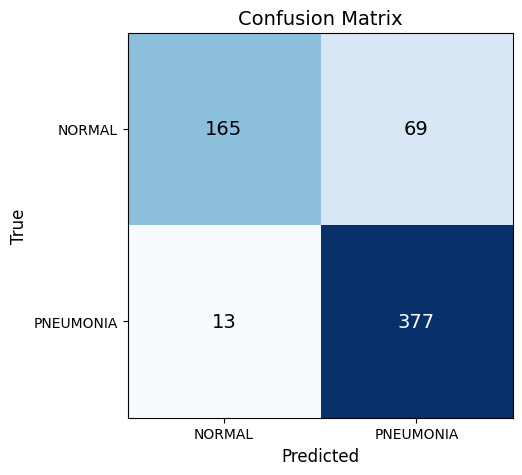

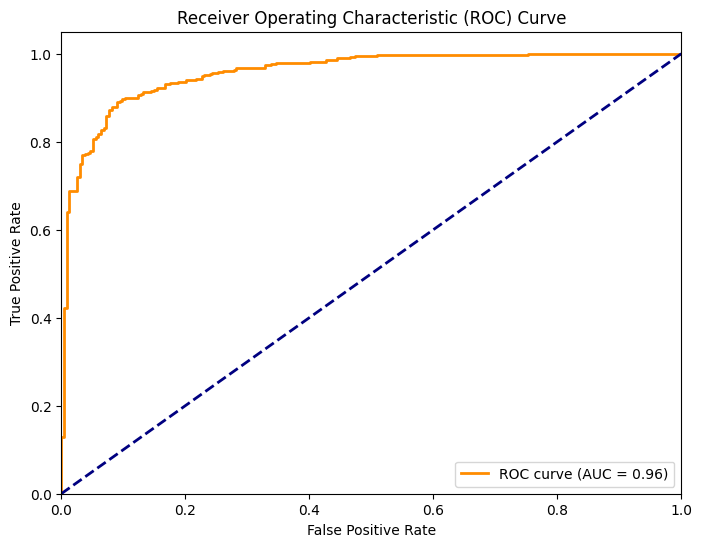


Area Under Curve (AUC) Score: 0.9579
Found 624 files belonging to 2 classes.

--- Examples of Misclassified Images ---

False Positives (NORMAL predicted as PNEUMONIA):


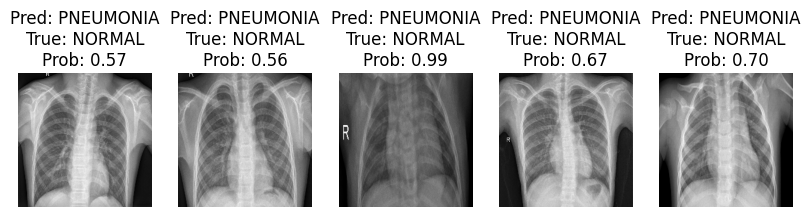


False Negatives (PNEUMONIA predicted as NORMAL):


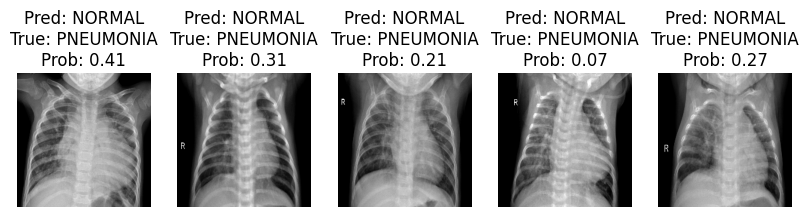

In [5]:
# --- 5. ENHANCED PERFORMANCE EVALUATION ---
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

# --- Original Evaluation Code ---
# Get true labels and predictions from the test set
y_true = np.concatenate([y.numpy().ravel() for _, y in test_ds])
y_prob = model.predict(test_ds).ravel() # Probabilities from the model
y_pred = (y_prob >= 0.5).astype(int) # Convert probabilities to class labels (0 or 1)

# Print Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(cm, cmap='Blues')
ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
ax.set_xticklabels(class_names); ax.set_yticklabels(class_names)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
for (i, j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha='center', va='center', color='white' if cm[i, j] > cm.max()/2 else 'black', fontsize=14)
plt.show()

# --- ADDITION 1: ROC CURVE AND AUC SCORE ---
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f"\nArea Under Curve (AUC) Score: {roc_auc:.4f}")

# --- ADDITION 2: VISUALIZE MISCLASSIFIED IMAGES ---
# We need an unprocessed dataset for clean visualization
unprocessed_test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, "test"), image_size=IMG_SIZE, batch_size=BATCH, shuffle=False
)

# Find indices of misclassified images
misclassified_indices = np.where(y_pred != y_true)[0]
correct_indices = np.where(y_pred == y_true)[0]

# Unbatch the dataset to access individual images
all_images = np.concatenate([x for x, y in unprocessed_test_ds])
all_labels = np.concatenate([y for x, y in unprocessed_test_ds])

# Plot a few False Positives (Normal predicted as Pneumonia)
print("\n--- Examples of Misclassified Images ---\n")
fp_indices = np.intersect1d(np.where(y_true == 0), np.where(y_pred == 1))
print("False Positives (NORMAL predicted as PNEUMONIA):")
plt.figure(figsize=(10, 4))
for i, index in enumerate(fp_indices[:5]): # Show up to 5 examples
    plt.subplot(1, 5, i + 1)
    plt.imshow(all_images[index].astype('uint8'))
    plt.title(f"Pred: PNEUMONIA\nTrue: NORMAL\nProb: {y_prob[index]:.2f}")
    plt.axis('off')
plt.show()

# Plot a few False Negatives (Pneumonia predicted as Normal)
fn_indices = np.intersect1d(np.where(y_true == 1), np.where(y_pred == 0))
print("\nFalse Negatives (PNEUMONIA predicted as NORMAL):")
plt.figure(figsize=(10, 4))
for i, index in enumerate(fn_indices[:5]): # Show up to 5 examples
    plt.subplot(1, 5, i + 1)
    plt.imshow(all_images[index].astype('uint8'))
    plt.title(f"Pred: NORMAL\nTrue: PNEUMONIA\nProb: {y_prob[index]:.2f}")
    plt.axis('off')
plt.show()

In [8]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 22.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=1ff5971f457ad23234ea7157fc423d6d36c2ed36fb54e89e671a50b31cc04167
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime



--- Generating LIME Explainability Visualization ---
Found 624 files belonging to 2 classes.
Generating LIME explanation... (This may take a moment)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━

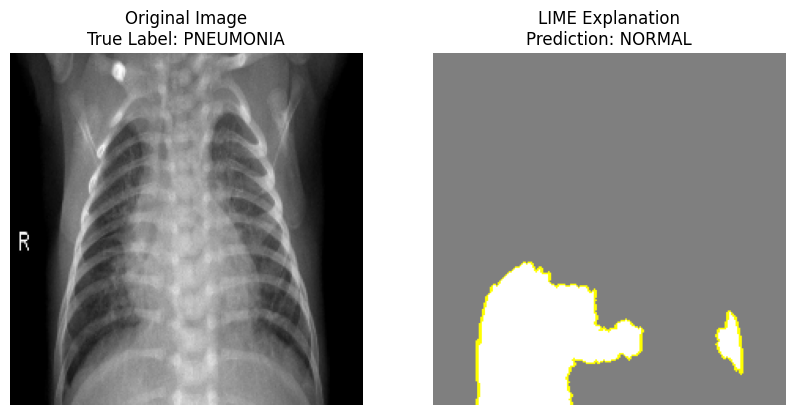

In [10]:
# Part 6 (Alternative 1): LIME (Local Interpretable Model-agnostic Explanations)
# Make sure these imports are at the TOP of your notebook
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import applications # <-- THE FIX IS ADDING THIS LINE

print("\n--- Generating LIME Explainability Visualization ---")

# We need an unprocessed dataset for clean visualization
unprocessed_test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, "test"),
    image_size=IMG_SIZE,
    batch_size=1,
    shuffle=True
)

# Function to make predictions in the format LIME expects
def predict_for_lime(images):
    # LIME provides images in a different format, so we preprocess them for VGG16
    processed_images = applications.vgg16.preprocess_input(images)
    # Get the model's prediction probability for the "PNEUMONIA" class
    preds = model.predict(processed_images)
    # We need to return probabilities for both classes: [P(Normal), P(Pneumonia)]
    return np.hstack((1 - preds, preds))

# Create a LIME explainer object
explainer = lime_image.LimeImageExplainer()

# Take one image from the test set to explain
for img_batch, label_batch in unprocessed_test_ds.take(1):
    original_img = img_batch[0].numpy().astype('uint8')
    true_label_index = int(label_batch.numpy()[0])

    print("Generating LIME explanation... (This may take a moment)")

    # Generate the explanation
    explanation = explainer.explain_instance(
        original_img,
        predict_for_lime,
        top_labels=2,
        hide_color=0,
        num_samples=1000
    )

    # Get the image and mask for the top predicted label
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=5,
        hide_rest=True
    )

    # Get the model's prediction
    pred_prob = model.predict(applications.vgg16.preprocess_input(img_batch))[0][0]
    prediction = "PNEUMONIA" if pred_prob > 0.5 else "NORMAL"
    true_label = class_names[true_label_index]

    # Display the result
    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(1, 2, 1)
    ax1.imshow(original_img)
    ax1.set_title(f"Original Image\nTrue Label: {true_label}")
    ax1.axis('off')

    ax2 = plt.subplot(1, 2, 2)
    ax2.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    ax2.set_title(f"LIME Explanation\nPrediction: {prediction}")
    ax2.axis('off')

    plt.show()

Found 624 files belonging to 2 classes.

--- Generating In-Text Explanations for Test Images ---

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


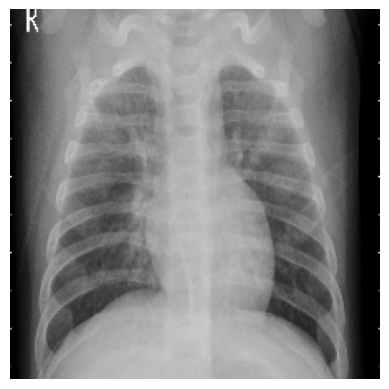

--- AI Analysis Report ---
True Label: PNEUMONIA

Finding: PNEUMONIA (Low Confidence: 56.7%)
Evidence: Some indicators suggestive of pneumonia were found, but the signs are not definitive.
Recommendation: For clinical use, this analysis requires review by a qualified radiologist.

------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


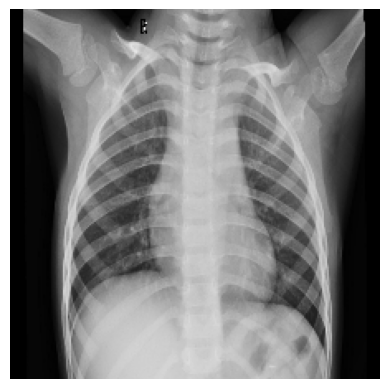

--- AI Analysis Report ---
True Label: NORMAL

Finding: NORMAL (Low Confidence: 66.2%)
Evidence: The scan appears largely normal, but some minor ambiguities prevent a high-confidence assessment.
Recommendation: For clinical use, this analysis requires review by a qualified radiologist.

------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


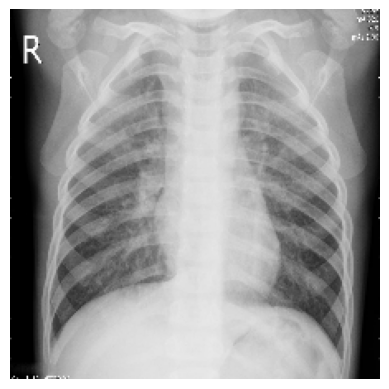

--- AI Analysis Report ---
True Label: PNEUMONIA

Finding: NORMAL (Low Confidence: 50.7%)
Evidence: The scan appears largely normal, but some minor ambiguities prevent a high-confidence assessment.
Recommendation: For clinical use, this analysis requires review by a qualified radiologist.

------------------------------


In [11]:
import numpy as np
import matplotlib.pyplot as plt

# --- Part 7: In-Text Explanation Generator ---

def generate_text_explanation(pred_prob, true_label_index, class_names):
    """
    Generates a human-readable text report based on the model's prediction.
    """
    prediction_index = 1 if pred_prob > 0.5 else 0
    prediction_name = class_names[prediction_index]
    true_label_name = class_names[true_label_index]

    report = f"--- AI Analysis Report ---\n"
    report += f"True Label: {true_label_name}\n\n"

    confidence_str = ""
    evidence_str = ""

    if prediction_name == 'PNEUMONIA':
        confidence = pred_prob * 100
        if confidence > 90:
            confidence_str = f"Finding: PNEUMONIA (High Confidence: {confidence:.1f}%)"
            evidence_str = "Evidence: Strong indicators of pneumonia, such as significant lung opacities, were detected."
        elif confidence > 70:
            confidence_str = f"Finding: PNEUMONIA (Moderate Confidence: {confidence:.1f}%)"
            evidence_str = "Evidence: Features consistent with pneumonia were detected. Clinical correlation is advised."
        else:
            confidence_str = f"Finding: PNEUMONIA (Low Confidence: {confidence:.1f}%)"
            evidence_str = "Evidence: Some indicators suggestive of pneumonia were found, but the signs are not definitive."

    else: # NORMAL
        confidence = (1 - pred_prob) * 100
        if confidence > 90:
            confidence_str = f"Finding: NORMAL (High Confidence: {confidence:.1f}%)"
            evidence_str = "Evidence: No significant indicators of pneumonia were detected in the visible lung fields."
        else:
            confidence_str = f"Finding: NORMAL (Low Confidence: {confidence:.1f}%)"
            evidence_str = "Evidence: The scan appears largely normal, but some minor ambiguities prevent a high-confidence assessment."

    report += f"{confidence_str}\n"
    report += f"{evidence_str}\n"
    report += "Recommendation: For clinical use, this analysis requires review by a qualified radiologist.\n"

    return report

# --- Generate and Print Reports for a Few Test Images ---

# Get the unprocessed images and their true labels again
unprocessed_test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, "test"),
    image_size=IMG_SIZE,
    batch_size=1,
    shuffle=True
)

print("\n--- Generating In-Text Explanations for Test Images ---\n")

for img_batch, label_batch in unprocessed_test_ds.take(3): # Generate for 3 examples
    # Preprocess the image to get a prediction
    processed_img = applications.vgg16.preprocess_input(img_batch)
    prediction_probability = model.predict(processed_img)[0][0]

    # Generate the report
    true_label_idx = int(label_batch.numpy()[0])
    explanation_report = generate_text_explanation(prediction_probability, true_label_idx, class_names)

    # Display the image and its report
    plt.imshow(img_batch[0].numpy().astype('uint8'))
    plt.axis('off')
    plt.show()
    print(explanation_report)
    print("-" * 30)
